<a href="https://colab.research.google.com/github/kratos45-jorch/TropicalFires/blob/main/Thermal_Anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/**** TEMPORAL ANOMALIES FOR ANDES FIRES*******
 * PIPELINE:
 * 1. DATASET DICTIONNARIE: Upload all data sets needed for the project
 * 1a. MASK AT 2000 m asl
 * 1b. CLIP BY AREA
      Same region as Roman-Cuesta et al (2014)
      12°N – 20°S, 84°W–62°W
 * 2. EXTRACT VEGETATION CLASSES
 * 3. ADD MODIS FIRE
      Get date
      Get altitude
      Get cover class
      
 * 4. CALCULATE statistics -
    4.1 Total monthtly averages and anomalies over the times period (12*20 years = 240 images)
    4.2.- Monthly averages and anomalies  per landclass type
        4.2.1 Need to relcassify classes
        4.2.1 Compute over different classes
    4.3.- Monthly averages and anomalies per country
   */

# **Import Libraries**

In [ ]:
import ee
import geemap
from datetime import datetime
import pandas as pd
import numpy as np

#Compte Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-villa45ramos')


### **Import Dataset**

In [ ]:
datasets= {'AndesTropi':ee.FeatureCollection("projects/ee-villa45ramos/assets/AndesTropi2"),
           'dem30m': ee.Image("USGS/SRTMGL1_003"),
           #'LandcoverProba':ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global"),
           'WorldCoverESA':ee.ImageCollection('ESA/WorldCover/v100'),
           'MODarea':ee.ImageCollection("MODIS/061/MCD64A1"),
           'datacountries':ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0"),
           'andes':ee.Geometry.BBox( -84.0, -30.0, -62.0, 12.0).buffer(1000)
}


# **CODIGO CONSOLIDADO**

## *Pretraitement MCD14ML CSV Format*

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fry Apr 5 15:27:42 2024
Version 1.0
@author: jvilla
"""

import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from tqdm.notebook import tqdm

def merge_csv(files_joined,name_sortie):
  list_files = glob.glob(files_joined)
  All_csv = pd.concat(map(pd.read_csv, list_files), ignore_index=True)
  All_csv.to_csv(name_sortie, index=False, encoding='utf-8-sig')

#Filtrar: Confidence: >80% (High Level Confidence) Type: 0 (presumed vegetation fire), 2 (other static land source)
def filt_csv(fichier):
  file_name = Path(fichier).stem
  df = pd.read_csv(fichier)
  fichier_fil=df[df['confidence'] >= 80]
  fichier_fil=fichier_fil[(fichier_fil['type'] == 0) | (fichier_fil['type'] == 2)]
  fichier_fil = fichier_fil.iloc[:, [0,1,5,6,7,9,11,12]]
  fichier_fil["country"]=file_name
  conditionlist = [
    (fichier_fil["latitude"] >= -5),
    (fichier_fil["latitude"] >= -8) & (fichier_fil["latitude"] < -5),
    (fichier_fil["latitude"] <= -8),
  ]
  choicelist = ["Zone_Equatorial", "Transition_Zone", "South_Zone"]
  fichier_fil["Zone_Clima"] = np.select(conditionlist, choicelist, default="Not Specified")
  return fichier_fil

def csv_to_shp(dtf,dir_sortie):
  dtf['coordinates'] = dtf[['longitude', 'latitude']].values.tolist()
  dtf['coordinates'] = dtf['coordinates'].apply(Point)
  gdtf = gpd.GeoDataFrame(dtf, geometry = 'coordinates')
  gdtf = gdtf.set_crs('EPSG:4326')
  return gdtf.to_file(dir_sortie)

def fusdatacsv(dict_csv):
  n=len(dict_csv)
  for k,i in zip(dict_csv.keys(),range(1,len(dict_csv)+1)):
    merge_csv(os.path.join(dict_csv[k][0],'modis*.csv'),dict_csv[k][1])
    print(f"Merge csv Terminée étape {i}/7")
    csv_to_shp(filt_csv(dict_csv[k][1]),dict_csv[k][2][:-3]+'shp')
    print(f"CSV to SHP filt Terminée {i}/7")

def mergShape(files_shapes,dir_Shpf):
  list_shapes = glob.glob(os.path.join(files_shapes,'*.shp'))
  GDF_list= list()
  GDF_list = [gpd.read_file(list_shapes[i]) for i in tqdm(range(len(list_shapes)))]
  AndesTropi = gpd.GeoDataFrame(pd.concat(GDF_list,ignore_index=True), crs=GDF_list[0].crs)
  return AndesTropi.to_file(dir_Shpf)

In [ ]:
dir_1='/content/drive/MyDrive/PFE_CIRAD_AMAP/'
dir_2='/content/drive/MyDrive/PFE_CIRAD_AMAP/Data_pays/'
dir_3='/content/drive/MyDrive/PFE_CIRAD_AMAP/shape_pays/'
dir_SHPf='/content/drive/MyDrive/PFE_CIRAD_AMAP/shape_pays/AndesTropiv3.shp'
pays=["Argentina","Bolivia","Chile","Colombia","Ecuador","Peru","Venezuela"]
datacsv= {f"csv{i}": [f'{dir_1}{pays[i]}', f'{dir_2}{pays[i]}.csv',f'{dir_3}{pays[i]}.shp'] for i in range(len(pays))}

In [ ]:
fusdatacsv(datacsv)
mergShape(dir_3,dir_SHPf)
print("Processus Pretraitement MCD14ML CSV Format Terminée")

👾***CHARGER SHAPEFILE LIKE A DATASET IN GEE***

> Ajouter une citation





## *Pretraitement MCD14ML in GEE*

In [ ]:
datasets= {'MCD14ML':ee.FeatureCollection("projects/ee-villa45ramos/assets/AndesTropiv3"),
           'dem30m': ee.Image("USGS/SRTMGL1_003"),
           'WorldCoverESA':ee.ImageCollection('ESA/WorldCover/v100'),
           'andes':ee.Geometry.BBox( -84.0, -30.0, -62.0, 12.0).buffer(1000)}

class AnomaliesThermiques:
  def __init__(self,**datasets):
    self.AOI = datasets['andes']
    self.dem = datasets['dem30m']
    self.cover = datasets['WorldCoverESA']
    self.mcd14ml = datasets['MCD14ML']

  def worldcover(self):
    def clipStudyArea(img):
      return img.clip(self.AOI)
    return self.cover.filterBounds(self.AOI).map(clipStudyArea).mosaic()

  def Extract_Fire_Activites(self):
    def datechange(fc):
      return fc.set('ddmmyy', ee.Date(fc.get('acq_date')).format('ddMMyy'))
    def coverelev(feat):
      geom = feat.geometry()
      wcover = self.worldcover().reduceRegion(ee.Reducer.mode(), feat.geometry(), 1000).get('Map')#mode car on cherche la couverture plus present dans le buffer de 1000m (resolution MODIS)
      elev30 = self.dem.clip(self.AOI).reduceRegion(ee.Reducer.median(), feat.geometry(), 1000).get('elevation')#mean car on cherche l'elevation moyenne dans le buffer de 1000m (resolution MODIS)
      return ee.Feature(geom).copyProperties(feat).set('wc', wcover).set('elev30',elev30)
    return self.mcd14ml.filterBounds(self.worldcover().geometry()).map(datechange).map(coverelev, True).filterMetadata('elev30', "greater_than", 2000)

MODWorldCoverv = AnomaliesThermiques(**datasets).Extract_Fire_Activites()
print("Processus FireActivity terminée")

In [ ]:
task = ee.batch.Export.table.toDrive(
    collection=MODWorldCoverv,
    description='MODWorldCoverv5',
    folder='/content/drive/MyDrive/PFE_CIRAD_AMAP',
    fileFormat='CSV')

task.start()

print("Processus Pretraitement MCD14ML in GEE terminée")

Processus Pretraitement MCD14ML in GEE terminée


## *Extraction surfaces WordlCover in GEE*

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 10 15:56:33 2024
Version 3.1
@author: jvilla
"""
import ee
import geemap
from tqdm.notebook import tqdm

#Compte Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-villa45ramos')

class AreaTotalCover:
  def __init__(self,codesoil,AOI,**datasets):
    self.countries = datasets['countries']
    self.cover = datasets['WorldCoverESA']
    self.dem = datasets['dem30m']
    self.codesoil=codesoil
    self.AOI = AOI

  def country(self):
    countries = ee.List([195,51,12,33,73,57,263]); #Peru, Chile, Argentina,Bolivia, Ecuador, Colombia, Venezuela
    countriesshp = self.countries.filter(ee.Filter.inList('ADM0_CODE',countries))
    filterc = ee.Filter.inList('ADM0_CODE',countries)
    countriesshp = self.countries.filter(filterc)
    def remove_non_polygons(geometry):
      return ee.Algorithms.If(ee.Algorithms.IsEqual(ee.Geometry(geometry).type()
                            , ee.String('Polygon'))
                            , ee.Feature(ee.Geometry(geometry)), None)
    def clean_polygon_feature(feature):
      geometries = feature.geometry().geometries();
      geometries_cleaned = ee.FeatureCollection(geometries.map(remove_non_polygons)).union().first();
      return ee.Feature(feature).setGeometry(geometries_cleaned.geometry())
    return countriesshp.map(clean_polygon_feature)

  def worldcover(self):
    def clipStudyArea(img):
      return img.clip(AOI)
    return self.cover.filterBounds(AOI).map(clipStudyArea).mosaic()

  def mask_soil(self):
    dem2 = self.dem.clip(AOI)
    elev = dem2.gte(2000)
    soil = self.worldcover().updateMask(elev)
    soilCover  = ee.Image(1).updateMask(soil.select('Map').eq(self.codesoil))#Grasland #Change of mask to updateMask
    area_pxa_soilCover_countries = soilCover.multiply(ee.Image.pixelArea()).reduceRegions(
                                                              collection = self.country(),
                                                              reducer = ee.Reducer.sum(),
                                                              scale = 10)
    def getArea(feature):
      area = ee.Number(feature.get('sum')).divide(1e6)
      return feature.set('area', area)
    return area_pxa_soilCover_countries.map(getArea).select('area','ADM0_NAME')

print("Processus FireActivity terminée")

Processus FireActivity terminée


In [ ]:
datasets= {'dem30m': ee.Image("USGS/SRTMGL1_003"),
           'WorldCoverESA':ee.ImageCollection('ESA/WorldCover/v100'),
           'countries':ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0")}

codesoil=40 #Changer code soil-> 10:TreeCover, 20:Shrubland, 30: Grassland, 40 Cropland

In [ ]:
grid = geemap.fishnet(ee.Geometry.BBox( -84.0, -30.0, -62.0, 12.0).buffer(1000), h_interval=4.5, v_interval=6.1, delta=1)
gridSize=grid.size().getInfo();
gridList=grid.toList(gridSize);

for i in tqdm(range(gridSize)):
  AOI = ee.Feature(gridList.get(i)).geometry()
  MOD_soil_Area = AreaTotalCover(codesoil,AOI,**datasets).mask_soil()
  task = ee.batch.Export.table.toDrive(
    collection=MOD_soil_Area,
    description=f'Cropland_Area_part{i}', #Changer name soil-> 10:TreeCover, 20:Shrubland, 30: Grassland, 40 Cropland
    folder='Inter_data_ThermalAnomalies',
    fileFormat='CSV')
  task.start()
  print(f"Execution part: {i}")
  #print(gridCell.getInfo())

  0%|          | 0/35 [00:00<?, ?it/s]

Execution part: 0
Execution part: 1
Execution part: 2
Execution part: 3
Execution part: 4
Execution part: 5
Execution part: 6
Execution part: 7
Execution part: 8
Execution part: 9
Execution part: 10
Execution part: 11
Execution part: 12
Execution part: 13
Execution part: 14
Execution part: 15
Execution part: 16
Execution part: 17
Execution part: 18
Execution part: 19
Execution part: 20
Execution part: 21
Execution part: 22
Execution part: 23
Execution part: 24
Execution part: 25
Execution part: 26
Execution part: 27
Execution part: 28
Execution part: 29
Execution part: 30
Execution part: 31
Execution part: 32
Execution part: 33
Execution part: 34


In [ ]:
with ee.profilePrinting():
   print(ee.Number(3.14).add(0.00159).getInfo())

3.1415900000000003


 EECU·s PeakMem Count  Description
  0.001     464     3  (plumbing)
   -       3.2k     3  Algorithm Number.add


In [ ]:
import ee
import geemap
Map = geemap.Map()
Map.addLayer(ee.Geometry.BBox( -84.0, -30.0, -62.0, 12.0).buffer(1000), {}, "BBOX")
Map.addLayer(geemap.fishnet(ee.Geometry.BBox( -84.0, -30.0, -62.0, 12.0).buffer(1000), h_interval=4.5, v_interval=6.1, delta=1), {}, "BBOX_coupe")#7 rows et 5 colums
Map

## *⭐Derniere Filtraje*

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fry Apr 17 15:42:30 2024
Version 2.0
@author: jvilla
"""

from datetime import datetime
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

dir_csv='/content/drive/MyDrive/ content drive MyDrive PFE_CIRAD_AMAP/MODWorldCoverv5.csv'


class filtZonesZeches():
	def __init__(self,dir_csv):
		self.dir_csv=dir_csv

	def filtr_cover(self):#Filtro couverture de sol
		dtf=pd.read_csv(self.dir_csv)
		return dtf[dtf['wc'] <= 40]
		print(dtf)

	def filtr_date(self):
		dtf=self.filtr_cover()
		dtf['month'] = pd.DatetimeIndex(dtf['acq_date']).month
		dtf['year'] = pd.DatetimeIndex(dtf['acq_date']).year
		return dtf
		print(dtf)

	def re_ord(self):
		dtf=self.filtr_date()
		new_dtf=dtf.iloc[:,[1,2,6,8,9,13,12,15,16,10,11]]
		new_dtf.columns=['Zone_Climatique','Date_Acquisition','Pays','Elevation(m)','FRP','WordlCover','Satellite','Mois','Annee','Lat(°)','Long(°)']
		return new_dtf
		print(new_dtf)

	def nom_soil(self):
		dtf=self.re_ord()
		dtf['WordlCover']=dtf['WordlCover'].replace([10, 20, 30, 40], ["Tree cover", "Shrubland", "Grassland", "Cropland"])
		return dtf
		print(dtf)

In [ ]:
MODWorldCover_fil= filtZonesZeches(dir_csv).nom_soil()#.sample(n=5, random_state=5)
#MODWorldCover_fil.head()

In [ ]:
MODWorldCover_fil.to_csv('/content/drive/MyDrive/PFE_CIRAD_AMAP/1_MCD14ML/Inter_data_ThermalAnomalies/MODWorldCover_fil.csv', index=False)
print("Processus Nettoyage des données MCD14ML en Pandas terminée")

Processus Nettoyage des données MCD14ML en Pandas terminée


Processus terminée en pandas, passer au Cluster Spatio-Temporal en Qgis

## **🎯 Graphs Thermal Anomalies General**

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fry Apr 22 10:46:18 2024
Version 1.1
@author: jvilla
"""

import pandas as pd

dir_csv='/content/drive/MyDrive/PFE_CIRAD_AMAP/1_MCD14ML/Inter_data_ThermalAnomalies/MODWorldCover_fil_stdscan15j.csv'

class filClusters():
	def __init__(self,dir_csv):
		self.dir_csv=dir_csv

	def filtr_clust(self):
		dtf=pd.read_csv(self.dir_csv)
		dtf_slice1=dtf[dtf['CLUSTER_ID'].isna()]#Fuegos Independientes
		dtf_slice2=dtf[~dtf['CLUSTER_ID'].isna()]#Fuegos Interdependientes
		dtf_slice2=dtf_slice2.sort_values(by=['Date_Acquisition'])
		dtf_slice2= dtf_slice2.drop_duplicates(subset=["CLUSTER_ID"],keep='first')
		dtf=pd.concat([dtf_slice1,dtf_slice2],axis=0,ignore_index=True)
		dtf=dtf.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]]
		return dtf
		print(dtf)

In [ ]:
clus=filClusters(dir_csv).filtr_clust()#.sample(n=5, random_state=5)
clus

Graphs BY Month end Year after divide Surface of soil

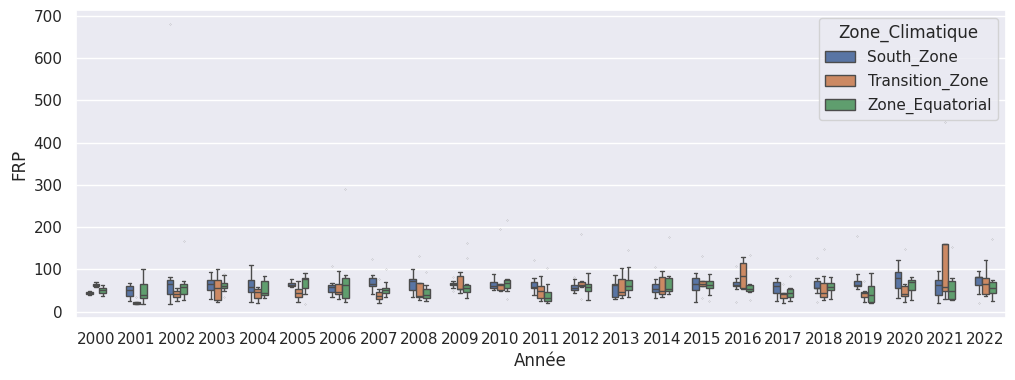

In [ ]:
import seaborn as sns

Thermal_anomalies_Anual=filClusters(dir_csv).filtr_clust()
Boxplot_data=Thermal_anomalies_Anual.groupby(['Zone_Climatique','Année','Mois'])['FRP'].count().reset_index()
Boxplot_data["frec_norm"] = (Boxplot_data["FRP"] -
                           Boxplot_data["FRP"].mean()) / Boxplot_data["FRP"].std()
sns.set(rc={"figure.figsize":(12, 4)}) #width=8, height=4
ax=sns.boxplot(data=Boxplot_data, x="Année", y="FRP", hue="Zone_Climatique", width=.5,fliersize=0.1)#,showfliers=False)#fliersize=0.1)
#ax.axvline(4.5, color=".3", dashes=(2, 2))
#ax.axvline(8.5, color=".3", dashes=(2, 2))

In [ ]:
Boxplot_data

In [ ]:
Boxplot_data=Thermal_anomalies_Anual.groupby(['Zone_Climatique','Année','Mois'])['FRP'].count().reset_index()


,Zone_Climatique,Année,Mois,FRP,frec_norm
0,South_Zone,2000,11,37,0.321308
1,South_Zone,2000,12,5,-0.448036
2,South_Zone,2001,6,2,-0.520162
3,South_Zone,2001,7,40,0.393434
4,South_Zone,2001,8,36,0.297266
...,...,...,...,...,...
552,Zone_Equatorial,2022,8,1,-0.544204
553,Zone_Equatorial,2022,9,6,-0.423994
554,Zone_Equatorial,2022,10,5,-0.448036
555,Zone_Equatorial,2022,11,3,-0.496120


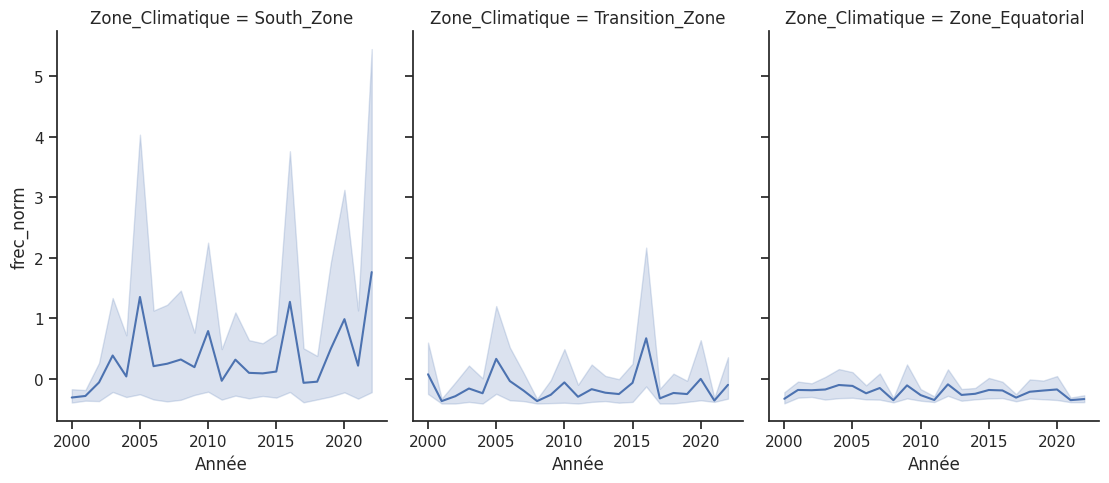

In [ ]:
#import seaborn as sns
sns.set_theme(style="ticks")

#dots = sns.load_dataset("dots")
rel_data=Thermal_anomalies_Anual.groupby(['Zone_Climatique','Pays','WordlCover','Année'])['FRP'].count().reset_index()
rel_data["frec_norm"] = (rel_data["FRP"] -
                           rel_data["FRP"].mean()) / rel_data["FRP"].std()

# Define the palette as a list to specify exact values
palette = sns.color_palette("tab10")

# Plot the lines on two facets
sns.relplot(
    data=rel_data,
    x="Année", y="frec_norm",
    #hue="coherence",
    #size="Pays",
    col="Zone_Climatique",
    kind="line",# size_order=["T1", "T2"],
    palette=palette,
    height=5, aspect=.75,
    #facet_kws=dict(sharex=False)
)

In [ ]:
rel_data=Thermal_anomalies_Anual.groupby(['Zone_Climatique','Année','Mois'])['FRP'].count().reset_index()
South_Zone = rel_data[rel_data["Zone_Climatique"] == 'South_Zone']
South_Zone["cum_percent"] = 100 * (South_Zone["FRP"].cumsum()/South_Zone["FRP"].sum())
South_Zone

,Zone_Climatique,Année,Mois,FRP,cum_percent
0,South_Zone,2000,11,37,0.427597
1,South_Zone,2000,12,5,0.485381
2,South_Zone,2001,6,2,0.508494
3,South_Zone,2001,7,40,0.970762
4,South_Zone,2001,8,36,1.386802
...,...,...,...,...,...
189,South_Zone,2022,8,107,92.638391
190,South_Zone,2022,9,135,94.198544
191,South_Zone,2022,10,250,97.087715
192,South_Zone,2022,11,210,99.514619


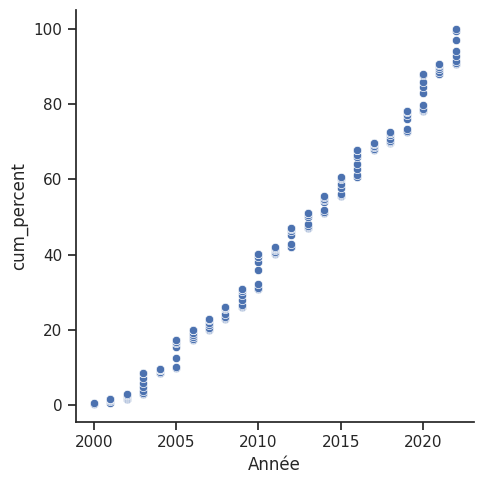

In [ ]:
sns.relplot(data=South_Zone,x="Année", y="cum_percent"
#,col="Zone_Climatique",kind='scatter'
)

## **🐘 Soil Surface** #

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 22 14:14:48 2024
Version 1.0
@author: jvilla
"""

import os
from pathlib import Path
import glob
import pandas as pd
from tqdm.notebook import tqdm

def merge_csv_SurfaceSoil(dir,pays):
  for i in tqdm(range(0,len(pays))):
    name=pays[i]
    path_fil=os.path.join(dir,f'*{name}*.csv')
    list_files = glob.glob(path_fil)
    All_csv = pd.concat(map(pd.read_csv, list_files), ignore_index=True)
    All_csv = All_csv.groupby(['ADM0_NAME'])['area'].sum().reset_index()
    All_csv.to_csv(f'{dir}/{name}_all.csv', index=False, encoding='utf-8-sig')#testee dans le code integree
    print(f"Merge csv Terminée étape {i}/3")

In [ ]:
dir_1='/content/drive/MyDrive/PFE_CIRAD_AMAP/1_MCD14ML/Inter_data_ThermalAnomalies'
pays=["TreeCover_Area_part","Shrubland_Area_part","Grassland_Area_part","Cropland_Area_part"]

merge_csv_SurfaceSoil(dir_1,pays)

print("Processus Surface Soil WordlCover CSV Format Terminée")

  0%|          | 0/4 [00:00<?, ?it/s]

Merge csv Terminée étape 0/4
Merge csv Terminée étape 1/4
Merge csv Terminée étape 2/4
Merge csv Terminée étape 3/4
Processus Surface Soil WordlCover CSV Format Terminée


In [ ]:
dtf=pd.read_csv('/content/drive/MyDrive/PFE_CIRAD_AMAP/1_MCD14ML/Inter_data_ThermalAnomalies/Grassland_Area_part_all.csv')
Grassland_area=dtf.groupby(['ADM0_NAME'])['area'].sum().reset_index()
#Grassland_area.head()
Grassland_area.to_csv('/content/drive/MyDrive/PFE_CIRAD_AMAP/1_MCD14ML/Inter_data_ThermalAnomalies/Grassland_Area_part_all2.csv', index=False, encoding='utf-8-sig')